# Ingeniería de Características para la Predicción de Demanda Eléctrica

Este notebook se centra en la creación y selección de características relevantes para la predicción de demanda eléctrica. Se desarrollarán las siguientes características:

1. Características temporales
   - Hora del día
   - Día de la semana
   - Mes del año
   - Temporada
   - Festivos y eventos especiales

2. Características meteorológicas
   - Temperatura media, máxima y mínima
   - Humedad
   - Condiciones climáticas
   - Agregaciones por región

3. Características de demanda histórica
   - Valores retardados (lags)
   - Medias móviles
   - Desviaciones estándar móviles

4. Otras características relevantes
   - Niveles de embalses
   - Precios de electricidad
   - Indicadores económicos (si están disponibles)

El objetivo es crear un conjunto rico de características que capturen los patrones y dependencias en la demanda eléctrica.

In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

## Configuración de Rango de Fechas

Define el rango de fechas para los datos que se procesarán en feature engineering.

**Nota**: Estos valores pueden ser sobrescritos por el Notebook 00 (Pipeline Maestro) cuando se ejecuta automáticamente.

In [2]:
# PARÁMETROS - Esta celda puede ser sobrescrita por papermill (NB00)
# Si ejecutas este notebook manualmente, modifica estos valores aquí
# Si lo ejecutas desde NB00, estos valores serán reemplazados automáticamente

# Configuración de rango de fechas para feature engineering
# None = usar todos los datos disponibles desde el inicio
FECHA_INICIO_DATOS = pd.Timestamp('2023-01-01 00:00:00')
# Por defecto: hasta el 2025-09-20 (puedes cambiarlo según necesites)
FECHA_FIN_DATOS = pd.Timestamp('2025-10-21 23:59:59')

In [3]:
# Mostrar configuración activa
print("="*80)
print("CONFIGURACIÓN DE FECHAS ACTIVA (NB02 - Feature Engineering)")
print("="*80)
print(f"Inicio: {'Desde el principio' if FECHA_INICIO_DATOS is None else FECHA_INICIO_DATOS}")
print(f"Fin:    {FECHA_FIN_DATOS}")
print("="*80)

CONFIGURACIÓN DE FECHAS ACTIVA (NB02 - Feature Engineering)
Inicio: 2023-01-01 00:00:00
Fin:    2025-10-21 23:59:59


In [4]:

# Configuración de visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Carga de Datos Preprocesados

Primero cargaremos los datos preprocesados del notebook anterior (01_data_preparation.ipynb). Esto incluirá:
1. Datos de demanda limpios
2. Datos meteorológicos agregados
3. Información de embalses
4. Calendario de eventos

Posteriormente, procederemos a crear nuevas características que serán útiles para nuestros modelos.

In [5]:
# Cargar datos procesados

def load_processed_data():
    try:
        demand_df = pd.read_parquet('artifacts/data/processed/processed_demand.parquet')
        weather_df = pd.read_parquet('artifacts/data/processed/processed_weather.parquet')
        reservoir_df = pd.read_parquet('artifacts/data/processed/processed_reservoirs.parquet')
        price_df = pd.read_parquet('artifacts/data/processed/processed_prices.parquet')
        return demand_df, weather_df, reservoir_df, price_df
    except FileNotFoundError:
        print("Archivos procesados no encontrados. Ejecuta primero el notebook 01_data_preparation.ipynb")
        return None, None, None, None

# Intentar cargar los datos procesados
demand_df, weather_df, reservoir_df, price_df = load_processed_data()

if demand_df is not None:
    print("Datos cargados exitosamente")
    print(f"Registros de demanda: {len(demand_df)}")
    print(f"Registros meteorológicos: {len(weather_df)}")
    print(f"Registros de embalses: {len(reservoir_df)}")
    print(f"Registros de precios: {len(price_df)}")
else:
    print("No se pudieron cargar los datos procesados")

Datos cargados exitosamente
Registros de demanda: 24600
Registros meteorológicos: 24600
Registros de embalses: 24600
Registros de precios: 24600


## Aplicar Filtros de Fecha

Aplicamos los filtros de fecha configurados en los parámetros para limitar el rango de datos a procesar.

In [6]:
# Aplicar filtros de fecha a todos los dataframes cargados
if demand_df is not None:
    print("Aplicando filtros de fecha...")
    print(f"Datos antes del filtrado:")
    print(f"  Demanda: {len(demand_df):,} registros")
    print(f"  Meteorología: {len(weather_df):,} registros")
    print(f"  Embalses: {len(reservoir_df):,} registros")
    print(f"  Precios: {len(price_df):,} registros")
    
    # Aplicar filtro de fecha de inicio si está configurado
    if FECHA_INICIO_DATOS is not None:
        demand_df = demand_df[demand_df['datetime'] >= FECHA_INICIO_DATOS].copy()
        weather_df = weather_df[weather_df['datetime'] >= FECHA_INICIO_DATOS].copy()
        reservoir_df = reservoir_df[reservoir_df['datetime'] >= FECHA_INICIO_DATOS].copy()
        price_df = price_df[price_df['datetime'] >= FECHA_INICIO_DATOS].copy()
        print(f"\n✓ Filtrado desde: {FECHA_INICIO_DATOS}")
    
    # Aplicar filtro de fecha de fin si está configurado
    if FECHA_FIN_DATOS is not None:
        demand_df = demand_df[demand_df['datetime'] <= FECHA_FIN_DATOS].copy()
        weather_df = weather_df[weather_df['datetime'] <= FECHA_FIN_DATOS].copy()
        reservoir_df = reservoir_df[reservoir_df['datetime'] <= FECHA_FIN_DATOS].copy()
        price_df = price_df[price_df['datetime'] <= FECHA_FIN_DATOS].copy()
        print(f"✓ Filtrado hasta: {FECHA_FIN_DATOS}")

    print(f"\nAplicamos los filtros desde {FECHA_INICIO_DATOS} hasta {FECHA_FIN_DATOS}")

    print(f"\nDatos después del filtrado:")
    print(f"  Demanda: {len(demand_df):,} registros")
    print(f"  Meteorología: {len(weather_df):,} registros")
    print(f"  Embalses: {len(reservoir_df):,} registros")
    print(f"  Precios: {len(price_df):,} registros")
    print("="*80)

Aplicando filtros de fecha...
Datos antes del filtrado:
  Demanda: 24,600 registros
  Meteorología: 24,600 registros
  Embalses: 24,600 registros
  Precios: 24,600 registros

✓ Filtrado desde: 2023-01-01 00:00:00
✓ Filtrado hasta: 2025-10-21 23:59:59

Aplicamos los filtros desde 2023-01-01 00:00:00 hasta 2025-10-21 23:59:59

Datos después del filtrado:
  Demanda: 24,600 registros
  Meteorología: 24,600 registros
  Embalses: 24,600 registros
  Precios: 24,600 registros


## Creación de Características Temporales

Comenzaremos creando características basadas en el tiempo, que son fundamentales para capturar patrones estacionales en la demanda eléctrica:

1. Características cíclicas de tiempo:
   - Hora del día (transformación cíclica)
   - Día de la semana
   - Mes del año
   - Día del año

2. Indicadores especiales:
   - Fin de semana
   - Festivo
   - Periodo vacacional
   - Temporada del año

La transformación cíclica es especialmente importante para variables como la hora del día, donde queremos mantener la naturaleza circular del tiempo (por ejemplo, 23:00 está más cerca de 00:00 que de 12:00).

In [7]:
# Funciones para crear características temporales
def crear_caracteristicas_temporales(df, columna_tiempo='datetime'):
    """
    Crea características temporales a partir de una columna de tiempo.
    
    Args:
        df: DataFrame con los datos
        columna_tiempo: Nombre de la columna que contiene la fecha/hora
    
    Returns:
        DataFrame con las nuevas características temporales
    """
    # Asegurarse de que la columna temporal es datetime
    df = df.copy()
    df[columna_tiempo] = pd.to_datetime(df[columna_tiempo])
    
    # Características básicas de tiempo
    df['hora_dia'] = df[columna_tiempo].dt.hour
    df['dia_semana'] = df[columna_tiempo].dt.dayofweek
    df['dia_mes'] = df[columna_tiempo].dt.day
    df['mes'] = df[columna_tiempo].dt.month
    df['dia_año'] = df[columna_tiempo].dt.dayofyear
    
    # Características cíclicas
    df['hora_sin'] = np.sin(2 * np.pi * df['hora_dia']/24)
    df['hora_cos'] = np.cos(2 * np.pi * df['hora_dia']/24)
    df['mes_sin'] = np.sin(2 * np.pi * df['mes']/12)
    df['mes_cos'] = np.cos(2 * np.pi * df['mes']/12)
    
    # Indicadores especiales
    df['fin_semana'] = df['dia_semana'].isin([5, 6]).astype(int)
    df['temporada'] = pd.cut(df['mes'], 
                           bins=[0, 3, 6, 9, 12], 
                           labels=['invierno', 'primavera', 'verano', 'otoño'])
    
    return df


Primeras filas con características temporales:


,datetime,real,hora_dia,dia_semana,dia_mes,mes,dia_año,hora_sin,hora_cos,mes_sin,mes_cos,fin_semana,temporada
0,2023-01-01 00:00:00,21419.667,0,6,1,1,1,0.000,1.000,0.500,0.866,1,invierno
1,2023-01-01 01:00:00,20627.083,1,6,1,1,1,0.259,0.966,0.500,0.866,1,invierno
2,2023-01-01 02:00:00,19437.083,2,6,1,1,1,0.500,0.866,0.500,0.866,1,invierno
3,2023-01-01 03:00:00,18331.750,3,6,1,1,1,0.707,0.707,0.500,0.866,1,invierno
4,2023-01-01 04:00:00,17712.167,4,6,1,1,1,0.866,0.500,0.500,0.866,1,invierno


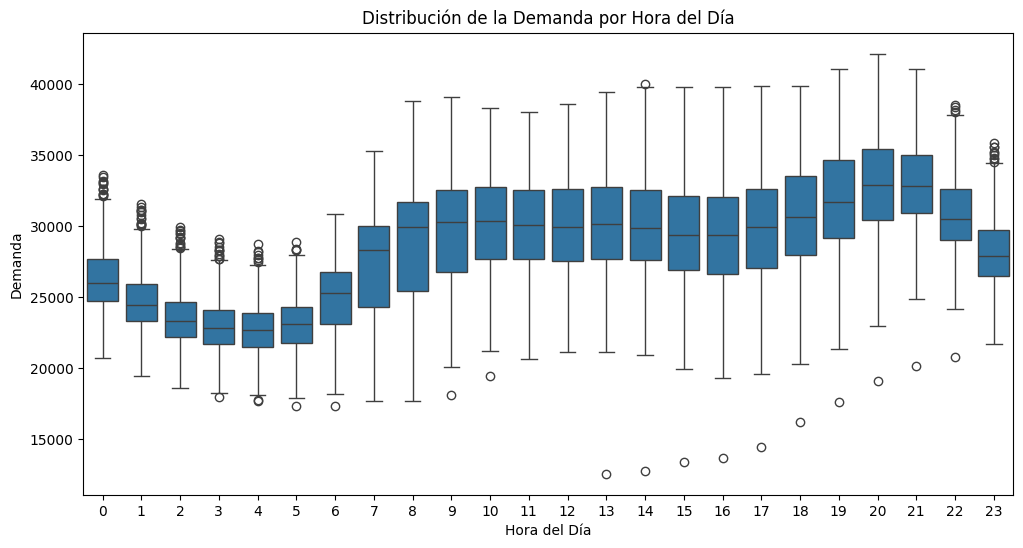

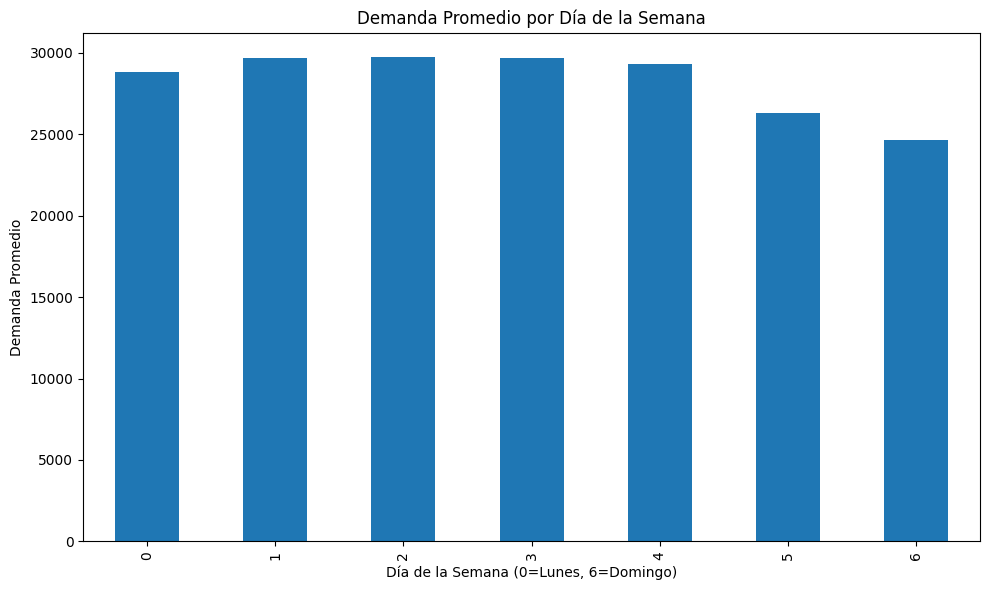

In [8]:
# Aplicar la creación de características temporales
if demand_df is not None:
    demand_df = crear_caracteristicas_temporales(demand_df)
    
    # Mostrar las primeras filas con las nuevas características
    print("\nPrimeras filas con características temporales:")
    display(demand_df.head())
    
    # Visualizar la distribución de la demanda por hora del día
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=demand_df, x='hora_dia', y='real')
    plt.title('Distribución de la Demanda por Hora del Día')
    plt.xlabel('Hora del Día')
    plt.ylabel('Demanda')
    plt.show()
    
    # Visualizar la demanda promedio por día de la semana
    plt.figure(figsize=(10, 6))
    demand_df.groupby('dia_semana')['real'].mean().plot(kind='bar')
    plt.title('Demanda Promedio por Día de la Semana')
    plt.xlabel('Día de la Semana (0=Lunes, 6=Domingo)')
    plt.ylabel('Demanda Promedio')
    plt.tight_layout()
    plt.show()

In [9]:
def crear_caracteristicas_temporales(df):
    """
    Crea características temporales basadas en la columna de datetime.
    """
    df = df.copy()
    # Asegurarse de que la columna temporal es datetime
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Características cíclicas
    df['hora_del_dia_sin'] = np.sin(2 * np.pi * df['datetime'].dt.hour/24)
    df['hora_del_dia_cos'] = np.cos(2 * np.pi * df['datetime'].dt.hour/24)
    df['dia_semana_sin'] = np.sin(2 * np.pi * df['datetime'].dt.dayofweek/7)
    df['dia_semana_cos'] = np.cos(2 * np.pi * df['datetime'].dt.dayofweek/7)
    df['mes_sin'] = np.sin(2 * np.pi * df['datetime'].dt.month/12)
    df['mes_cos'] = np.cos(2 * np.pi * df['datetime'].dt.month/12)

    # Características categóricas
    df['hora_del_dia'] = df['datetime'].dt.hour
    df['dia_semana'] = df['datetime'].dt.dayofweek
    df['mes'] = df['datetime'].dt.month
    df['trimestre'] = df['datetime'].dt.quarter
    df['año'] = df['datetime'].dt.year
    df['es_festivo'] = df['datetime'].dt.date.isin(holidays.Spain(years=df['datetime'].dt.year.unique().tolist())).astype(int)

    # Características binarias
    df['es_finde'] = df['dia_semana'].isin([5, 6]).astype(int)
    df['es_laboral'] = (~df['dia_semana'].isin([5, 6])).astype(int)
    df['es_hora_pico_mañana'] = df['hora_del_dia'].between(7, 9).astype(int)
    df['es_hora_pico_tarde'] = df['hora_del_dia'].between(18, 20).astype(int)
    
    return df

def crear_lags_y_medias_moviles(df, columna_target='real', lags=[1, 24, 48, 168]):
    """
    Crea características de valores retardados y medias móviles.
    """
    df = df.copy()
    # Valores retardados
    for lag in lags:
        df[f'lag_{lag}h'] = df[columna_target].shift(lag)
    
    # Medias móviles
    # 6h, 12h, 24h, 48h, 1 semana
    ventanas = [6, 12, 24, 48, 168]  
    for ventana in ventanas:
        df[f'media_movil_{ventana}h'] = df[columna_target].rolling(window=ventana).mean()
        df[f'std_movil_{ventana}h'] = df[columna_target].rolling(window=ventana).std()
        
    return df


In [10]:
# Cargar datos preprocesados
print("Cargando datos procesados...")
demand_df = pd.read_parquet('artifacts/data/processed/processed_demand.parquet')
weather_df = pd.read_parquet('artifacts/data/processed/processed_weather.parquet')
reservoirs_df = pd.read_parquet('artifacts/data/processed/processed_reservoirs.parquet')
price_df = pd.read_parquet('artifacts/data/processed/processed_prices.parquet')

# Aplicar filtros de fecha si están configurados
for df_name, df in [('demand', demand_df), ('weather', weather_df), ('reservoirs', reservoirs_df), ('price', price_df)]:
    if FECHA_INICIO_DATOS is not None:
        df = df[df['datetime'] >= FECHA_INICIO_DATOS]
        print(f"Aplicando filtro inicio en {df_name}: desde {FECHA_INICIO_DATOS}")
    if FECHA_FIN_DATOS is not None:
        df = df[df['datetime'] <= FECHA_FIN_DATOS]
        print(f"Aplicando filtro fin en {df_name}: hasta {FECHA_FIN_DATOS}")
    
    # Actualizar el dataframe
    if df_name == 'demand':
        demand_df = df
    elif df_name == 'weather':
        weather_df = df
    elif df_name == 'reservoirs':
        reservoirs_df = df
    elif df_name == 'price':
        price_df = df

# Crear características temporales SOLO en demand_df
print("\nCreando características temporales...")
demand_features = crear_caracteristicas_temporales(demand_df)

weather_features = weather_df.copy()
reservoirs_features = reservoirs_df.copy()
price_features = price_df.copy()

# Crear lags y medias móviles
print("Creando lags y medias móviles...")
demand_features = crear_lags_y_medias_moviles(demand_features, columna_target='real')

# Mostrar información del dataset resultante
print("\nInformación del dataset con características:")
print(f"Dimensiones: {demand_features.shape}")
print("\nColumnas creadas:")
print(demand_features.columns.tolist())

# Comprobamos que existe existe la carpeta de features
Path('artifacts/data/features').mkdir(parents=True, exist_ok=True)

# Guardar dataset con características
demand_features.to_parquet('artifacts/data/features/features_demand.parquet')
print("\nDataset con características guardado en artifacts/data/features/features_demand.parquet")
weather_features.to_parquet('artifacts/data/features/features_weather.parquet')
print("Dataset meteorológico con características guardado en artifacts/data/features/features_weather.parquet")
reservoirs_features.to_parquet('artifacts/data/features/features_reservoirs.parquet')
print("Dataset de embalses con características guardado en artifacts/data/features/features_reservoirs.parquet")
price_features.to_parquet('artifacts/data/features/features_prices.parquet')
print("Dataset de precios con características guardado en artifacts/data/features/features_prices.parquet")

Cargando datos procesados...
Aplicando filtro inicio en demand: desde 2023-01-01 00:00:00
Aplicando filtro fin en demand: hasta 2025-10-21 23:59:59
Aplicando filtro inicio en weather: desde 2023-01-01 00:00:00
Aplicando filtro fin en weather: hasta 2025-10-21 23:59:59
Aplicando filtro inicio en reservoirs: desde 2023-01-01 00:00:00
Aplicando filtro fin en reservoirs: hasta 2025-10-21 23:59:59
Aplicando filtro inicio en price: desde 2023-01-01 00:00:00
Aplicando filtro fin en price: hasta 2025-10-21 23:59:59

Creando características temporales...
Creando lags y medias móviles...

Información del dataset con características:
Dimensiones: (24600, 32)

Columnas creadas:
['datetime', 'real', 'hora_del_dia_sin', 'hora_del_dia_cos', 'dia_semana_sin', 'dia_semana_cos', 'mes_sin', 'mes_cos', 'hora_del_dia', 'dia_semana', 'mes', 'trimestre', 'año', 'es_festivo', 'es_finde', 'es_laboral', 'es_hora_pico_mañana', 'es_hora_pico_tarde', 'lag_1h', 'lag_24h', 'lag_48h', 'lag_168h', 'media_movil_6h', 's

## Unión de Datos 

A continuación, uniremos los datos . Para esto:
1. Agregaremos los datos 
2. Calcularemos medias ponderadas según la población de cada ciudad en el de meteo
3. Alinearemos los timestamps para asegurar una correcta unión
4. Manejaremos los valores faltantes de forma apropiada

In [11]:
# Definir pesos de población para las principales ciudades
# Estos pesos son aproximados basados en la población relativa que puede demandar electricidad según los ultimos datos del INE

pesos_ciudades = {
    'albacete': 0.008943,
    'alicante': 0.045363,
    'almeria': 0.016711,
    'avila': 0.003591,
    'badajoz': 0.015198,
    'barcelona': 0.133783,
    'bilbao': 0.026242,
    'burgos': 0.008017,
    'caceres': 0.008784,
    'cadiz': 0.028428,
    'castellon': 0.013640,
    'ciudad_real': 0.011110,
    'cordoba': 0.017591,
    'a_coruna': 0.025292,
    'cuenca': 0.004426,
    'girona': 0.017908,
    'granada': 0.021231,
    'guadalajara': 0.006007,
    'huelva': 0.012194,
    'huesca': 0.005036,
    'jaen': 0.014028,
    'leon': 0.010183,
    'lleida': 0.010002,
    'logrono': 0.007207,
    'lugo': 0.007452,
    'madrid': 0.159364,
    'malaga': 0.040151,
    'murcia': 0.035573,
    'ourense': 0.006888,
    'oviedo': 0.022764,
    'palencia': 0.003545,
    'pontevedra': 0.021340,
    'salamanca': 0.007430,
    'san_sebastian': 0.016259,
    'santander': 0.013323,
    'segovia': 0.003478,
    'sevilla': 0.044466,
    'soria': 0.001987,
    'tarragona': 0.019308,
    'teruel': 0.003026,
    'toledo': 0.016101,
    'valencia': 0.061656,
    'valladolid': 0.011698,
    'vitoria': 0.007520,
    'zamora': 0.003794,
    'zaragoza': 0.021950
}

def agregar_datos_meteo(weather_df, pesos_ciudades):
    """
    Agrega los datos meteorológicos usando una media ponderada por población.
    """
    # Obtener las columnas base (sin sufijos de ciudad)
    cols_base = ['temperature_2m', 'precipitation', 'cloud_cover', 'wind_speed_10m']
    
    # Normalizar pesos para que sumen 1
    total = sum(pesos_ciudades.values())
    pesos_norm = {k: v/total for k, v in pesos_ciudades.items()}
    
    # Inicializar DataFrame agregado
    weather_agg = pd.DataFrame()
    weather_agg['datetime'] = weather_df['datetime'].unique()
    
    # Para cada variable meteorológica base
    for col_base in cols_base:
        weighted_sum = pd.Series(0, index=weather_agg.index)
        total_weight = 0
        
        # Sumar las contribuciones ponderadas de cada ciudad
        for ciudad, peso in pesos_norm.items():
            col_ciudad = f"{col_base}_{ciudad}"
            if col_ciudad in weather_df.columns:
                weighted_sum += weather_df[col_ciudad].values * peso
                total_weight += peso
        
        # Normalizar por el peso total efectivo
        if total_weight > 0:
            weather_agg[col_base] = weighted_sum / total_weight
    
    return weather_agg

# Agregar datos meteorológicos
print("Agregando datos meteorológicos...")
weather_agg = agregar_datos_meteo(weather_df, pesos_ciudades)

# Unir con el dataset principal de weather_agg y price_features
print("Uniendo datasets...")
features_complete = pd.merge(demand_features, weather_agg, 
                           left_on='datetime', 
                           right_on='datetime', 
                           how='left')
features_complete = pd.merge(features_complete, price_features, 
                           left_on='datetime', 
                           right_on='datetime', 
                           how='left')

# Interpolar valores faltantes
print("Manejando valores faltantes...")
features_complete = features_complete.interpolate(method='linear')

# Mostrar información del dataset combinado
print("\nInformación del dataset completo:")
print(f"Dimensiones: {features_complete.shape}")
print(f"Columnas meteorológicas añadidas: {len(weather_agg.columns) - 1}")
print(f"Columnas de precios añadidas: {len(price_features.columns) - 1}")
print("\nPrimeras filas del dataset completo:")
display(features_complete.head())
print(features_complete.info())

# Cambiamos la columna real a demanda para mejorar la claridad
features_complete = features_complete.rename(columns={'real': 'demanda'})



Agregando datos meteorológicos...
Uniendo datasets...
Manejando valores faltantes...

Información del dataset completo:
Dimensiones: (24600, 33)
Columnas meteorológicas añadidas: 0
Columnas de precios añadidas: 1

Primeras filas del dataset completo:


,datetime,real,hora_del_dia_sin,hora_del_dia_cos,dia_semana_sin,dia_semana_cos,mes_sin,mes_cos,hora_del_dia,dia_semana,mes,trimestre,año,es_festivo,es_finde,es_laboral,es_hora_pico_mañana,es_hora_pico_tarde,lag_1h,lag_24h,lag_48h,lag_168h,media_movil_6h,std_movil_6h,media_movil_12h,std_movil_12h,media_movil_24h,std_movil_24h,media_movil_48h,std_movil_48h,media_movil_168h,std_movil_168h,price
0,2023-01-01 00:00:00,21419.667,0.000,1.000,-0.782,0.623,0.500,0.866,0,6,1,1,2023,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.450
1,2023-01-01 01:00:00,20627.083,0.259,0.966,-0.782,0.623,0.500,0.866,1,6,1,1,2023,0,1,0,0,0,21419.667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.010
2,2023-01-01 02:00:00,19437.083,0.500,0.866,-0.782,0.623,0.500,0.866,2,6,1,1,2023,0,1,0,0,0,20627.083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.070
3,2023-01-01 03:00:00,18331.750,0.707,0.707,-0.782,0.623,0.500,0.866,3,6,1,1,2023,0,1,0,0,0,19437.083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.690
4,2023-01-01 04:00:00,17712.167,0.866,0.500,-0.782,0.623,0.500,0.866,4,6,1,1,2023,0,1,0,0,0,18331.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.910


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24600 entries, 0 to 24599
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             24600 non-null  datetime64[ns]
 1   real                 24600 non-null  float64       
 2   hora_del_dia_sin     24600 non-null  float64       
 3   hora_del_dia_cos     24600 non-null  float64       
 4   dia_semana_sin       24600 non-null  float64       
 5   dia_semana_cos       24600 non-null  float64       
 6   mes_sin              24600 non-null  float64       
 7   mes_cos              24600 non-null  float64       
 8   hora_del_dia         24600 non-null  int32         
 9   dia_semana           24600 non-null  int32         
 10  mes                  24600 non-null  int32         
 11  trimestre            24600 non-null  int32         
 12  año                  24600 non-null  int32         
 13  es_festivo           24600 non-

In [12]:
# Sabemos que el 2025-04-27 y 2025-04-28 fueron anomalías
# Cambiamos los valores de esos dias hora por hora con los del día 2025-04-26 y 2025-04-29 respectivamente
features_complete.loc[features_complete['datetime'].dt.date == pd.Timestamp('2025-04-27').date(), 'demanda'] = features_complete.loc[features_complete['datetime'].dt.date == pd.Timestamp('2025-04-26').date(), 'demanda']
features_complete.loc[features_complete['datetime'].dt.date == pd.Timestamp('2025-04-28').date(), 'demanda'] = features_complete.loc[features_complete['datetime'].dt.date == pd.Timestamp('2025-04-29').date(), 'demanda']

# Guardar dataset completo
features_complete.to_parquet('artifacts/data/features/features_complete.parquet')
print("\nDataset completo guardado en artifacts/data/features/features_complete.parquet")


Dataset completo guardado en artifacts/data/features/features_complete.parquet
